In [72]:
import warnings
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer

In [73]:
with open('./mod_05_topic_10_various_data.pkl', 'rb') as fl:
    datasets = pickle.load(fl)

In [74]:
concrete = datasets['concrete']

components = ['Cement',
              'BlastFurnaceSlag',
              'FlyAsh',
              'Water',
              'Superplasticizer',
              'CoarseAggregate',
              'FineAggregate']

concrete['Components'] = concrete[components].gt(0).sum(axis=1)

concrete[components + ['Components']].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,102.0,153.0,0.0,192.0,0.0,887.0,942.0,5
1,108.3,162.4,0.0,203.5,0.0,938.2,849.0,5
2,116.0,173.0,0.0,192.0,0.0,909.8,891.9,5
3,122.6,183.9,0.0,203.5,0.0,958.2,800.1,5
4,132.0,206.5,160.9,178.9,5.5,866.9,735.6,7
5,132.0,207.0,161.0,179.0,5.0,867.0,736.0,7
6,133.0,200.0,0.0,192.0,0.0,927.4,839.2,5
7,133.0,210.0,0.0,196.0,3.0,949.0,795.0,6
8,133.1,210.2,0.0,195.7,3.1,949.4,795.3,6
9,134.7,0.0,165.7,180.2,10.0,961.0,804.9,6


In [75]:
scaler = StandardScaler()
# concrete_scaled = scaler.fit_transform(concrete[components])
concrete_scaled = scaler.fit_transform(concrete)

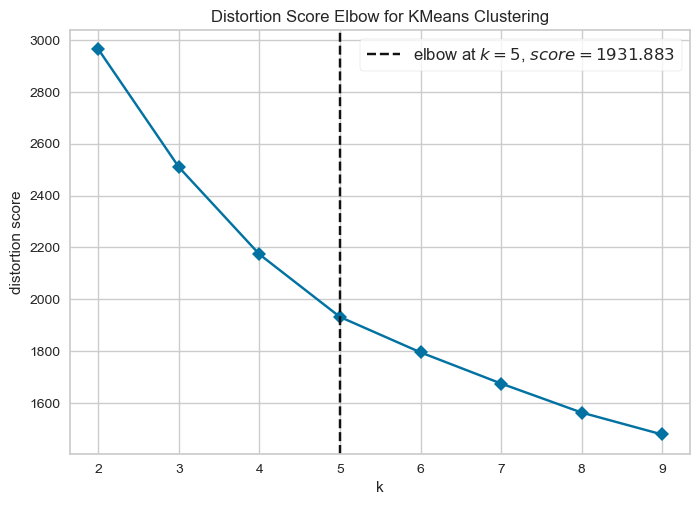

In [76]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    model_kmn = KMeans(random_state=42)
    visualizer = KElbowVisualizer(model_kmn, k=(2, 10), timings=False)

    visualizer.fit(concrete_scaled)
    visualizer.show()

    

In [77]:
optimal_k = visualizer.elbow_value_
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

In [78]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    concrete['Cluster'] = kmeans.fit_predict(concrete_scaled)

In [79]:
cluster_summary = concrete.groupby('Cluster')[components + ['Components', 'CompressiveStrength']].median()

In [80]:
cluster_sizes = concrete.groupby('Cluster').size()
cluster_summary['Cluster Size'] = cluster_sizes

In [81]:
print(cluster_summary)

         Cement  BlastFurnaceSlag  FlyAsh  Water  Superplasticizer  \
Cluster                                                              
0         166.0            186.70     0.0  192.0              0.00   
1         164.0            118.00   115.6  195.0              8.50   
2         212.0              0.00   124.8  171.5              9.50   
3         339.0              0.00     0.0  188.0              0.00   
4         360.8            119.85     0.0  166.0              9.25   

         CoarseAggregate  FineAggregate  Components  CompressiveStrength  \
Cluster                                                                    
0                  977.0         748.50         5.0               33.190   
1                  879.6         736.60         7.0               32.240   
2                 1005.8         793.50         6.0               40.390   
3                 1040.0         774.50         4.0               33.995   
4                  918.5         786.25         6.0  

###

### Аналіз результатів
1. Різні пропорції компонентів у кластерах
    - Кластер 0: Помірний вміст цементу (166.0), високий рівень доменного шлаку (186.70), відсутність флюашу та суперпластифікатора. Міцність на стиск: 33.190 (середній показник). Кластер представляє рецептури, які використовують шлак для заміни цементу, що може знижувати вартість, але впливає на міцність.
    - Кластер 1: Збалансований вміст цементу (164.0), доменного шлаку (118.00), флюашу (115.6), води (195.0) і суперпластифікатора (8.50). Міцність на стиск: 32.240 (середній показник).Комплексна рецептура, яка може забезпечувати різноманітні властивості бетону завдяки використанню великої кількості компонентів.
    - Кластер 2: Високий вміст цементу (212.0), флюашу (124.8), помірний вміст води (171.5) і суперпластифікатора (9.50). Міцність на стиск: 40.390 (вища за середню). Рецептури з підвищеною міцністю завдяки високому вмісту цементу.
    - Кластер 3: Дуже високий вміст цементу (339.0), відсутність шлаку та флюашу, помірна кількість води (188.0). Міцність на стиск: 33.995 (середній показник). Прості рецептури з фокусом на високий вміст цементу.
    - Кластер 4: Високий вміст цементу (360.8), помірна кількість шлаку (119.85) і суперпластифікатора (9.25). Міцність на стиск: 58.760 (найвищий показник). Рецептури, спрямовані на досягнення максимальної міцності.
2. Кількість компонентів
    - Кластер 1 має найбільше компонентів (по 7), що вказує на більш комплексні рецептури.
    - Кластер 3 має найменше компонентів (4), що може свідчити про рецептури з простішими складовими, орієнтуючись на доступність або дешевизну компонентів.
3. Розмір кластерів
    - Кластер 1 має найбільший розмір (107), що означає, що більшість рецептур потрапляють саме в цю групу.
    - Кластер 4 має найменший розмір (74), що може вказувати на менш поширені рецептури, можливо, зі специфічними вимогами.

### Висновки:
Отримані кластері дають уявлення про використання різних компонентів і їх кількість, що дає змогу зробити про можливі характеристики отриманого бетону і його міцність.